In [ ]:
!pip install pyspark

In [ ]:
#Import statements
from pyspark.sql import SparkSession,Row
from pyspark.sql.functions import col, sum,when,exp
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from pyspark.ml.functions import vector_to_array
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
seed=99

In [ ]:
#Create a Spark session
spark = SparkSession.builder.appName("SuperstoreAnalysis").getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")#Set legacy date parser due to issues with date format in new version

In [ ]:
#Read CSV data
superstore_data_path = 'superstore_data.csv' #File path
superstore_df = spark.read.csv(superstore_data_path, header=True, inferSchema=True)
superstore_df.show()

+-----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
|   Id|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|
+-----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
| 1826|      1970|Graduation|      Divorced| 84835|      0|       0|  6/16/2014|      0|     189|      104|            379|            111|             189|         2

#Data Preprocessing

In [ ]:
#Check the schema
superstore_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- Response: integer (nullable = true)
 |-- Complain: integer (nullable = true)



In [ ]:
#Convert the two date fields to date format and check schema again
superstore_df = superstore_df.withColumn('Year_Birth', F.to_date(superstore_df['Year_Birth']))
superstore_df = superstore_df.withColumn('Dt_Customer', F.to_date(superstore_df['Dt_Customer'], 'MM/dd/yyyy'))
superstore_df.printSchema()
superstore_df.show()

root
 |-- Id: integer (nullable = true)
 |-- Year_Birth: date (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: date (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- Response: integer (nullable = true)
 |-- Complain: integer (nullable = true)

+-----+----------+--------

In [ ]:
#Checking for missing values

# Count the number of null values in each column
null_counts = superstore_df.select(
    *[sum(col(c).isNull().cast("int")).alias(c) for c in superstore_df.columns]
)
null_counts.show()

+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
| Id|Year_Birth|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|
+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
|  0|         0|        0|             0|    24|      0|       0|          0|      0|       0|        0|              0|              0|               0|           0|         

From the above output we can see that only income has 24 missing values. We can impute these missing values using median of income for their respective education level

In [ ]:
#Fill missing income values based on median income for their respective education level

#Compute the median income by education level
education_window = Window().partitionBy('Education')
superstore_df = superstore_df.withColumn('MedianIncome', F.expr('percentile_approx(Income, 0.5)').over(education_window))

# Update missing income values
superstore_df = superstore_df.withColumn('Income', F.when(superstore_df['Income'].isNull(), superstore_df['MedianIncome']).otherwise(superstore_df['Income']))

# Drop the temporary column used for computation
superstore_df = superstore_df.drop('MedianIncome')

# Show the updated DataFrame
superstore_df.show()

+-----+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
|   Id|Year_Birth|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|
+-----+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
| 4073|1954-01-01| 2n Cycle|       Married| 63564|      0|       0| 2014-01-29|      0|     769|       80|            252|             15|              34|          65| 

In [ ]:
#Explore the two categorical variables Marital_Status and Education level
superstore_df.groupBy('Marital_Status').count().show()
superstore_df.groupBy('Education').count().show()

+--------------+-----+
|Marital_Status|count|
+--------------+-----+
|          YOLO|    2|
|      Together|  580|
|       Married|  864|
|        Absurd|    2|
|         Widow|   77|
|      Divorced|  232|
|         Alone|    3|
|        Single|  480|
+--------------+-----+

+----------+-----+
| Education|count|
+----------+-----+
|  2n Cycle|  203|
|       PhD|  486|
|    Master|  370|
|Graduation| 1127|
|     Basic|   54|
+----------+-----+



We can see two categories which dont make sense in Maritial Status - Yolo and Absurd. Since these contain a total of only 4 rows we can go ahead and drop them. Also we can combine the category Alone with single

In [ ]:
#Drop rows where 'Marital_Status' is 'YOLO' or 'Absurd'
superstore_df = superstore_df.filter(~superstore_df['Marital_Status'].isin(['YOLO', 'Absurd']))
#Convert 'Alone' to 'Single'
superstore_df = superstore_df.withColumn('Marital_Status', F.when(superstore_df['Marital_Status'] == 'Alone', 'Single').otherwise(superstore_df['Marital_Status']))
superstore_df.groupBy('Marital_Status').count().show()

+--------------+-----+
|Marital_Status|count|
+--------------+-----+
|      Together|  580|
|       Married|  864|
|         Widow|   77|
|      Divorced|  232|
|        Single|  483|
+--------------+-----+



The two date columns indicate the customers date of birth and when the customer became a member of the store. We can convert this to age and years a customer has been a memeber by subtracting the current data from the respective dates. Since the exatct date the data was collected is not mentioned, looking at the dates in the data we can assume this data was collected around 2015 and we will use that as the curent date.

In [ ]:
#Get the age and number of days the custoemr has been a memeber

current_date = F.to_date(F.lit('1/1/2015'), 'MM/dd/yyyy')#Set current date to 2015

# Calculate the number of days the customer has been a memeber
superstore_df = superstore_df.withColumn('Customer_Days', F.datediff(current_date, 'Dt_Customer'))

# Calculate the age of the customer
superstore_df=superstore_df.withColumn('Customer_Age', F.year(current_date) - F.year('Year_Birth'))

superstore_df.show()

+-----+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+-------------+------------+
|   Id|Year_Birth|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|Customer_Days|Customer_Age|
+-----+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+-------------+------------+
| 4073|1954-01-01| 2n Cycle|       Married| 63564|      0|       0| 2014-01-29|      0| 

In [ ]:
 #Drop the columns which are not required
 superstore_df = superstore_df.drop(*["Year_Birth", "Id", "Dt_Customer"])
 superstore_df.show()

+---------+--------------+------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+-------------+------------+
|Education|Marital_Status|Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|Customer_Days|Customer_Age|
+---------+--------------+------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+-------------+------------+
| 2n Cycle|       Married| 63564|      0|       0|      0|     769|       80|            252|             15|              34|          65|                1|             10|  

# EDA and Visulaization

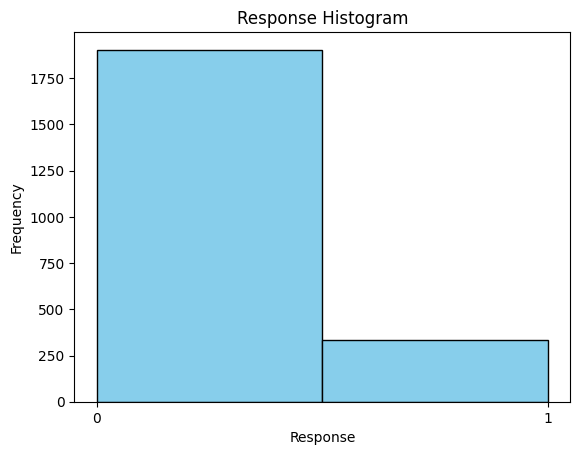

In [ ]:
#Distribution of responsr

data = superstore_df.toPandas()
plt.hist(data['Response'], bins=2, edgecolor='k', color='skyblue')
plt.title("Response Histogram")
plt.xlabel("Response")
plt.ylabel("Frequency")
plt.xticks([0, 1])  # Set x-axis ticks to be 0 and 1
plt.show()


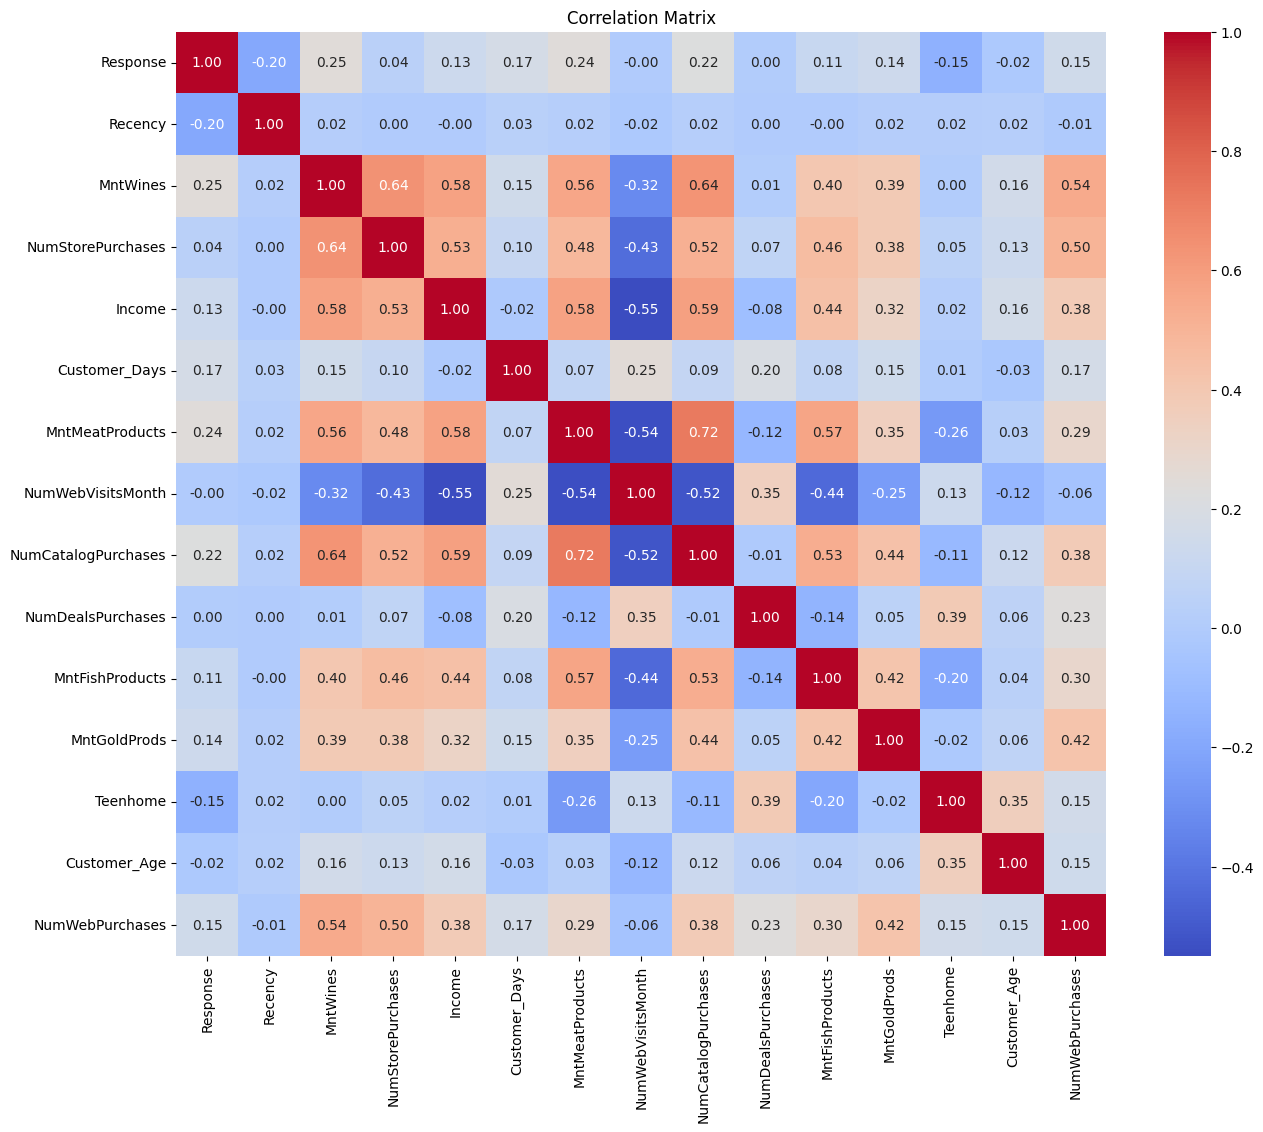

In [ ]:
#Plot correlation matrix
data = superstore_df.toPandas()

correlation_matrix = data[["Response", "Recency", "MntWines", "NumStorePurchases","Income","Customer_Days",
                           "MntMeatProducts","NumWebVisitsMonth", "NumCatalogPurchases", "NumDealsPurchases",
                           "MntFishProducts","MntGoldProds", "Teenhome", "Customer_Age", "NumWebPurchases"]].corr()


plt.figure(figsize=(15, 12))


sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


The correlation matrix reveals insights into relationships between different variables. Notably, there is a positive correlation between "MntWines" (amount spent on wines) and both "Income" and "NumStorePurchases," suggesting that higher income levels and more store purchases are associated with increased spending on wines. The negative correlation between "Recency" and "Response" suggests that as the "Recency" of interactions increases (i.e., more time has passed since the last interaction), there is a tendency for a lower likelihood of positive responses to campaigns.

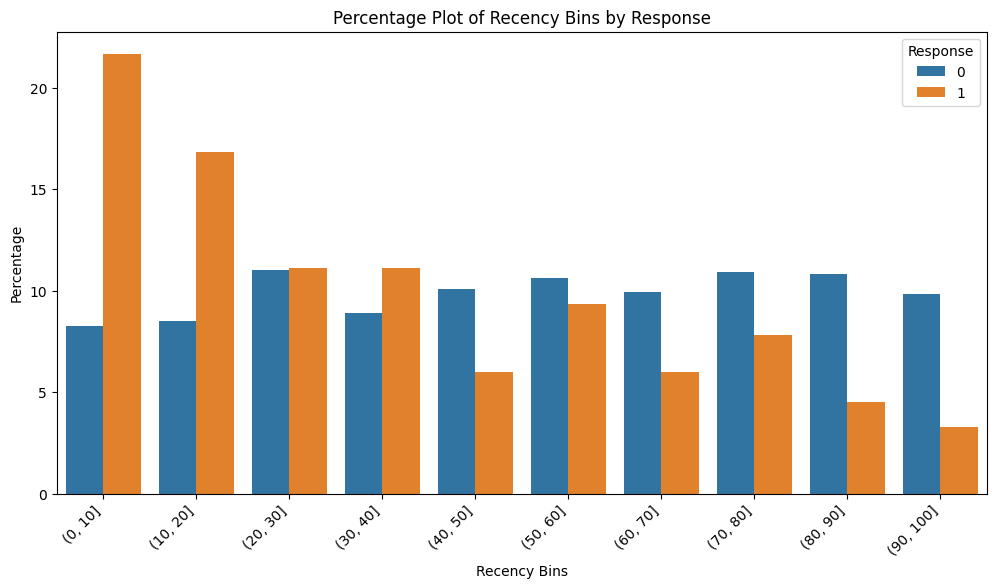

In [ ]:
# Assuming superstore_df is your PySpark DataFrame
pandas_df = superstore_df.toPandas()

# Calculate the total count of each response category
total_counts = pandas_df['Response'].value_counts()

# Define bin edges based on unique values
bin_edges = range(0, max(pandas_df['Recency']) + 11, 10)

# Create a new column 'Recency_Bin' with bin labels
pandas_df['Recency_Bin'] = pd.cut(pandas_df['Recency'], bins=bin_edges, include_lowest=False, precision=0)

# Calculate the percentage of each response category within each bin
percentage_df = pandas_df.groupby(['Recency_Bin', 'Response']).size() / pandas_df.groupby('Response').size() * 100
percentage_df = percentage_df.reset_index(name='Percentage')

# Set the size of the figure for better readability
plt.figure(figsize=(12, 6))

# Create bar plot using Seaborn
sns.barplot(x='Recency_Bin', y='Percentage', hue='Response', data=percentage_df)
plt.xlabel('Recency Bins')
plt.ylabel('Percentage')
plt.title('Percentage Plot of Recency Bins by Response')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()


In the Recency vs. Response plot, it clearly indicates that the recency is inversely proportional to the percentage of people responding positively to the campaign. When the recency has a lower value between 0-10 the percentage of people responding positively is the maximum. Additionally, it is also noteworthy that in the bins with lower values for recency, the positive percenatge is higher than negative percentage.

Text(0.5, 1.0, 'Average Income by Response')

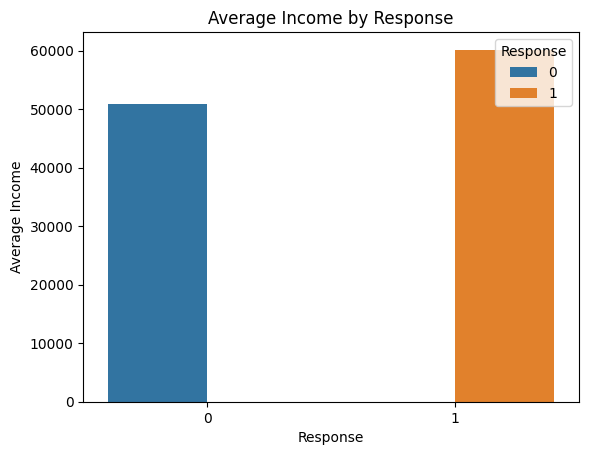

In [ ]:
#Average Income according to response

df = superstore_df.toPandas()
df=df.groupby(["Response"])["Income"].mean().reset_index()
sns.barplot(x='Response', y='Income', hue='Response', data=df)
plt.xlabel('Response')
plt.ylabel('Average Income')
plt.title('Average Income by Response')



Text(0.5, 1.0, 'Average MntWines by Response')

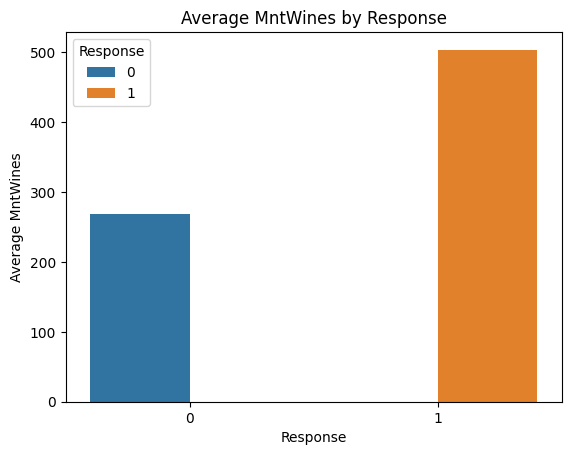

In [ ]:
#Average amount spend on alchohol me according to response
df = superstore_df.toPandas()
df=df.groupby(["Response"])["MntWines"].mean().reset_index()
sns.barplot(x='Response', y='MntWines', hue='Response', data=df)
plt.xlabel('Response')
plt.ylabel('Average MntWines')
plt.title('Average MntWines by Response')


Text(0.5, 1.0, 'Average Income by Education')

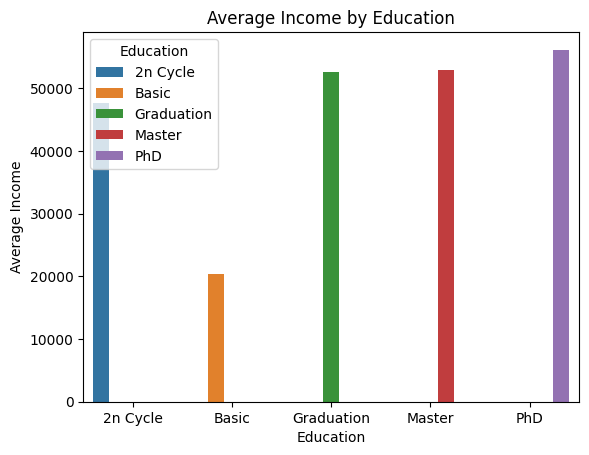

In [ ]:
#Average Income according to Eeducation level

df = superstore_df.toPandas()
df=df.groupby(["Education"])["Income"].mean().reset_index()
sns.barplot(x='Education', y='Income', hue='Education', data=df)
plt.xlabel('Education')
plt.ylabel('Average Income')
plt.title('Average Income by Education')

#Feature Engineering

In [ ]:
#One hot encode the catogorical variables and convert all features to vectors
stages=[]

cat_cols= ["Education", "Marital_Status"]
for c in cat_cols:
    stringIndexer = StringIndexer(inputCol=c, outputCol=c + "_index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], \
            outputCols=[c + "_vec"],dropLast=False)
    stages += [stringIndexer, encoder]

num_cols = ["Income", "Kidhome", "Teenhome","Recency","MntWines","MntFruits",\
            "MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds",\
            "NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases",\
            "NumWebVisitsMonth","Complain","Customer_Days","Customer_Age"]
assemblerInputs = [c + "_vec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
fe_pipe = Pipeline(stages=stages)

In [ ]:
#Apply the fe steps
superstore_fe = fe_pipe.fit(superstore_df).transform(superstore_df)

In [ ]:
superstore_fe.show()

+---------+--------------+------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+-------------+------------+---------------+-------------+--------------------+------------------+--------------------+
|Education|Marital_Status|Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|Customer_Days|Customer_Age|Education_index|Education_vec|Marital_Status_index|Marital_Status_vec|            features|
+---------+--------------+------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+-------------+-------

In [ ]:
#One hot encoding output to interpret feature importance
superstore_fe.groupBy("Marital_Status",vector_to_array("Marital_Status_vec")).count().collect()

[Row(Marital_Status='Divorced', UDF(Marital_Status_vec)=[0.0, 0.0, 0.0, 1.0, 0.0], count=232),
 Row(Marital_Status='Single', UDF(Marital_Status_vec)=[0.0, 0.0, 1.0, 0.0, 0.0], count=483),
 Row(Marital_Status='Together', UDF(Marital_Status_vec)=[0.0, 1.0, 0.0, 0.0, 0.0], count=580),
 Row(Marital_Status='Married', UDF(Marital_Status_vec)=[1.0, 0.0, 0.0, 0.0, 0.0], count=864),
 Row(Marital_Status='Widow', UDF(Marital_Status_vec)=[0.0, 0.0, 0.0, 0.0, 1.0], count=77)]

In [ ]:
#One hot encoding output to interpret feature importance
superstore_fe.groupBy("Education",vector_to_array("Education_vec")).count().collect()

[Row(Education='Basic', UDF(Education_vec)=[0.0, 0.0, 0.0, 0.0, 1.0], count=54),
 Row(Education='PhD', UDF(Education_vec)=[0.0, 1.0, 0.0, 0.0, 0.0], count=484),
 Row(Education='2n Cycle', UDF(Education_vec)=[0.0, 0.0, 0.0, 1.0, 0.0], count=203),
 Row(Education='Graduation', UDF(Education_vec)=[1.0, 0.0, 0.0, 0.0, 0.0], count=1126),
 Row(Education='Master', UDF(Education_vec)=[0.0, 0.0, 1.0, 0.0, 0.0], count=369)]

#Train test split

We split the data into train and test. Since our data has imbalanced classes we ensure the train and test data have equal proportions of both classes using stratified sampling

In [ ]:
#Distrubtion of target variable
target_distribution = superstore_fe.groupBy("Response").count().collect()
target_distribution_dict = {row["Response"]: row["count"] for row in target_distribution}
fractions = {key: 0.8 for key in target_distribution_dict.keys()}
print(target_distribution_dict)
print(fractions)

{1: 332, 0: 1904}
{1: 0.8, 0: 0.8}


In [ ]:
#Train test split
train_data = superstore_fe.stat.sampleBy("Response",fractions, seed)
test_data = superstore_fe.subtract(train_data)

In [ ]:
#Train and test data
print("Train data")
print(train_data.groupBy("Response").count().collect())
print("Test data")
print(test_data.groupBy("Response").count().collect())

Train data
[Row(Response=1, count=273), Row(Response=0, count=1529)]
Test data
[Row(Response=1, count=52), Row(Response=0, count=315)]


In [ ]:
#Standard scaler to scale the features for the modelling
scaler = StandardScaler().setInputCol('features') \
        .setOutputCol('scaled_features').fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

#Models

##Logistic Regression

In [ ]:
#Logsitic model
log_reg = LogisticRegression(featuresCol='scaled_features', labelCol='Response')

#Fit the model
log_reg_model=log_reg.fit(train_data)

#Get perdictions
train_predictions_log=log_reg_model.transform(train_data)
test_predictions_log= log_reg_model.transform(test_data)

#Evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", \
                 labelCol="Response",metricName="areaUnderROC")

#Get train and test AUC
log_train_auc=evaluator.evaluate(train_predictions_log)
log_test_auc=evaluator.evaluate(test_predictions_log)
print("Test AUC score: "+str(log_test_auc*100)+"%")

#Confusion Matricx
preds_and_labels = test_predictions_log.select(['prediction','Response'])
preds_and_labels=preds_and_labels.withColumn("Response",col("Response").cast("float"))
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

Test AUC score: 63.321123321123316%


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[302.  13.]
 [ 36.  16.]]


## Weighted logistic regeression

In [ ]:
#Assign class weights
train_data = train_data.withColumn("response_weight", when(col("Response") == 0, 0.1).otherwise(0.9))

#Logsitic model with class weights
log_reg_wt = LogisticRegression(featuresCol='scaled_features', labelCol='Response',weightCol='response_weight')

#Fit the model
log_reg_model_wt=log_reg_wt.fit(train_data)

#Get perdictions
train_predictions_log_wt=log_reg_model_wt.transform(train_data)
test_predictions_log_wt= log_reg_model_wt.transform(test_data)

#Evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", \
                 labelCol="Response",metricName="areaUnderROC")
#Get train and test AUC

log_train_auc=evaluator.evaluate(train_predictions_log_wt)
log_test_auc=evaluator.evaluate(test_predictions_log_wt)


print("Test AUC score: "+str(log_test_auc*100)+"%")

preds_and_labels = test_predictions_log_wt.select(['prediction','Response'])
preds_and_labels=preds_and_labels.withColumn("Response",col("Response").cast("float"))
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

Test AUC score: 75.15567765567765%
[[213. 102.]
 [  9.  43.]]


In [ ]:
#GTB model
gbt = GBTClassifier(featuresCol = 'features',labelCol = 'Response',seed=seed)

# grid
grid = ParamGridBuilder().addGrid(gbt.maxDepth, [3,4,5,6,7]).addGrid(gbt.stepSize,[0.1,0.2,0.3]).build()

# evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", \
                 labelCol="Response",metricName="areaUnderROC")
# crossvalidator
cv = CrossValidator(estimator=gbt, estimatorParamMaps=grid, evaluator=evaluator,numFolds=3)

# fit model
cvModel = cv.fit(train_data)

# print test AUC
test_predictions_gbt= cvModel.transform(test_data)
gbt_test_auc=evaluator.evaluate(test_predictions_gbt)
print("Test AUC score: "+str(gbt_test_auc*100)+"%")

#Confusion Matrix
preds_and_labels = test_predictions_gbt.select(['prediction','Response'])
preds_and_labels=preds_and_labels.withColumn("Response",col("Response").cast("float"))
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())
# print out the best values for your hyperparameters
print('Best Parmaters: ', cvModel.bestModel._java_obj.paramMap())

Test AUC score: 59.819902319902305%
[[286.  29.]
 [ 37.  15.]]
Best Parmaters:  {
	GBTClassifier_79b546265b58-featuresCol: features,
	GBTClassifier_79b546265b58-labelCol: Response,
	GBTClassifier_79b546265b58-maxDepth: 6,
	GBTClassifier_79b546265b58-seed: 99,
	GBTClassifier_79b546265b58-stepSize: 0.3
}


## Weighted GBT

In [ ]:
#gbt model
gbt_wt = GBTClassifier(featuresCol = 'features',labelCol = 'Response',seed=seed,weightCol='response_weight')

# grid
grid = ParamGridBuilder().addGrid(gbt_wt.maxDepth, [3,4,5,6,7]).addGrid(gbt_wt.stepSize,[0.1,0.2,0.3]).build()

# evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", \
                 labelCol="Response",metricName="areaUnderROC")
# crossvalidator
cv_wt = CrossValidator(estimator=gbt_wt, estimatorParamMaps=grid, evaluator=evaluator,numFolds=3)

# fit model
cvModel_wt = cv_wt.fit(train_data)

# print test AUC
test_predictions_gbt_wt= cvModel_wt.bestModel.transform(test_data)
gbt_test_auc_wt=evaluator.evaluate(test_predictions_gbt_wt)
print("Test AUC score: "+str(gbt_test_auc_wt*100)+"%")

#Confusion matrix
preds_and_labels = test_predictions_gbt_wt.select(['prediction','Response'])
preds_and_labels=preds_and_labels.withColumn("Response",col("Response").cast("float"))
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())
# print out the best values for your hyperparameters
print('Best Parmaters: ', cvModel_wt.bestModel._java_obj.paramMap())

Test AUC score: 77.06043956043956%
[[225.  90.]
 [  9.  43.]]
Best Parmaters:  {
	GBTClassifier_0a351965568a-featuresCol: features,
	GBTClassifier_0a351965568a-labelCol: Response,
	GBTClassifier_0a351965568a-maxDepth: 3,
	GBTClassifier_0a351965568a-seed: 99,
	GBTClassifier_0a351965568a-stepSize: 0.1,
	GBTClassifier_0a351965568a-weightCol: response_weight
}


#Feature importance

In [ ]:
feature_list=["Graduation","PhD","Master","2n Cycle","Basic","Married",\
              "Together","Single","Divorced","Widow"]+num_cols

In [ ]:
#Get feature importance from model
coefficients = cvModel_wt.bestModel.featureImportances.toArray()
data = list(zip(feature_list, coefficients))

#Map features and feature importande
schema = StructType([
    StructField("Features", StringType(), True),
    StructField("Importance", DoubleType(), True)
])

rdd = spark.sparkContext.parallelize(data)

#Display feature importance
df_2 = rdd.map(lambda x: Row(column1=x[0], column2=float(x[1]))).toDF(schema)
df_2.orderBy(["Importance"], ascending=[0]).show(40)

+-------------------+--------------------+
|           Features|          Importance|
+-------------------+--------------------+
|            Recency| 0.15265251903638694|
|             Income| 0.10461547120134547|
|  NumStorePurchases|  0.1039716123292832|
|           MntWines| 0.10111984927285025|
|      Customer_Days| 0.08640276352081917|
|  NumWebVisitsMonth| 0.08328460892749007|
|    MntMeatProducts| 0.07182778810710734|
|NumCatalogPurchases| 0.05127927506857202|
|           Together| 0.04459808636894345|
|  NumDealsPurchases| 0.03418773055058907|
|       MntGoldProds|0.031773008624282596|
|                PhD| 0.02886917929668628|
|           Teenhome| 0.02794021152369607|
|    MntFishProducts|0.027883137607812407|
|            Married|0.023050621985114986|
|    NumWebPurchases|0.009971985547233438|
|       Customer_Age|0.008236552679198794|
|          MntFruits|0.005144803675951011|
|              Basic|0.003190794676637458|
|   MntSweetProducts|                 0.0|
|         G

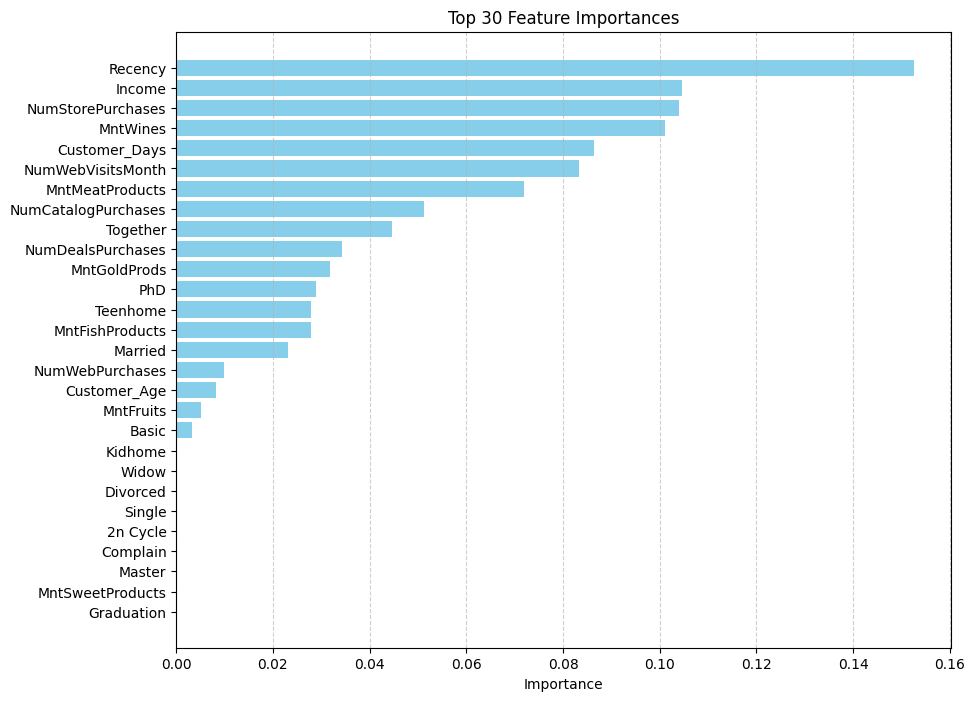

In [ ]:
# Plot feature importance
feature_importance_df = df_2.orderBy(["Importance"], ascending=[1]).limit(30).toPandas()

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Features'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Show the plot
plt.show()

#Probability Ranking

In [ ]:
#Rank customers in decreasing order of likleeness of prurchase gold membership
test_predictions_gbt=test_predictions_gbt.withColumn("Accept_Prob",vector_to_array(col("probability"))[1])
output=test_predictions_gbt.select("Response","Accept_Prob","prediction").\
          orderBy(["Accept_Prob"], ascending=[0])

In [ ]:
output.show(10)

+--------+------------------+----------+
|Response|       Accept_Prob|prediction|
+--------+------------------+----------+
|       1|0.9943077344401939|       1.0|
|       1|0.9887520747322488|       1.0|
|       0|0.9784336405800229|       1.0|
|       0|0.9691213338837502|       1.0|
|       0|0.9595890619500704|       1.0|
|       0|0.9557706934353215|       1.0|
|       0|0.9551066848904789|       1.0|
|       0|0.9487240072664186|       1.0|
|       1|0.9221236155533225|       1.0|
|       0|0.9156893884993217|       1.0|
+--------+------------------+----------+
only showing top 10 rows



In [ ]:
# Save output in csv file
output.toPandas().to_csv("./output.csv",index=False)